In [1]:
import numpy as np
import urllib
import json
import gzip
import scipy.optimize
import matplotlib.pyplot as plt
import statistics
import random
from collections import defaultdict # Dictionaries with default values
import string
import math
from sklearn import linear_model
import ast

In [2]:
def readData(path):
    file = gzip.open(path)
    for l in file:
        yield json.loads(l)
    

In [3]:
path = "renttherunway_final_data.json.gz"

In [4]:
dataset = list(readData(path))

In [5]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [6]:
count = 0
small = 0
large = 0
fit_types = set()
body_types = set()
category_types = set()
ages = []
ratings = []
for item in dataset:
    if "age" in item.keys():
        ages.append(item['age'])
    category_types.add(item["category"])
    ratings.append(item['rating'])
    fit_types.add(item["fit"])
    if item["fit"] == "fit":
        count += 1
    elif item["fit"] == 'small':
        small += 1
    else:
        large += 1
    if "body type" in item.keys():
        body_types.add(item["body type"])
        #count += 1
print(count)
print(small)
print(large)

142058
25779
24707


In [7]:
len(dataset)

192544

In [8]:
ratings = [int(r) for r in ratings if r]
ages = [int(r) for r in ages if r]

(array([  1046.,      0.,   2791.,      0.,  10697.,      0.,  53391.,
        124537.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 8 artists>)

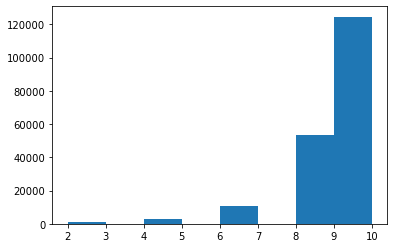

In [9]:
plt.hist(ratings, bins = 8)

(array([2.6000e+01, 1.0000e+01, 1.2000e+01, 9.0000e+00, 4.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 7.0000e+00, 1.9000e+01, 4.4000e+01, 1.5700e+02,
        3.5700e+02, 5.3700e+02, 2.5080e+03, 1.8820e+03, 2.5360e+03,
        3.5050e+03, 4.8420e+03, 7.3160e+03, 2.0925e+04, 1.3589e+04,
        1.4145e+04, 1.4522e+04, 1.3508e+04, 1.1882e+04, 1.9179e+04,
        7.7100e+03, 6.4850e+03, 5.5890e+03, 4.5620e+03, 4.3680e+03,
        6.4300e+03, 2.5890e+03, 2.3280e+03, 2.2040e+03, 2.0660e+03,
        2.1510e+03, 3.4580e+03, 1.2560e+03, 1.0490e+03, 9.1500e+02,
        1.1060e+03, 9.3900e+02, 1.4530e+03, 6.9200e+02, 5.1000e+02,
        3.6200e+02, 3.2300e+02, 5.2200e+02, 2.3500e+02, 1.4300e+02,
        1.3400e+02, 9.3000e+01, 5.4000e+01, 1.3900e+02, 4.7000e+01,
        1.0000e+01, 1.3000e+01, 8.0000e+00, 2.0000e+00, 1.7000e+01,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

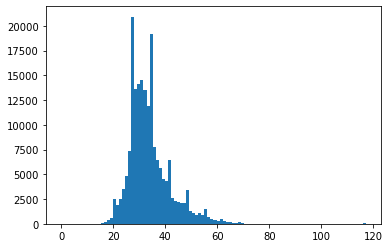

In [10]:
plt.hist(ages, bins = 100)

In [11]:
statistics.median(ages)

32.0

In [12]:
len(dataset)

192544

In [13]:
dataset_final = []
for d in dataset:
    if "body type" in d.keys() and "weight" in d.keys() and "height" in d.keys() and "rating" in d.keys() and "review_text" in d.keys():
        if d["body type"] and d["weight"] and d["fit"] and d["height"] and d["rating"] and d["review_text"]:
            dataset_final.append(d)

In [14]:
len(dataset_final)

153439

CREATE TRAIN, TEST, VALID

In [15]:
#list of positive samples
fits = [d for d in dataset_final if d["fit"] == "fit"]

In [16]:
#list of negative samples
not_fit = [d for d in dataset_final if d["fit"] != "fit"]

In [17]:
#create a new balanced datset where half of the items are not fit and half are fit
shuffler = random.Random(27)
shuffler.shuffle(fits)
new_dataset = fits[0:len(not_fit)]
new_dataset += not_fit

In [18]:
random.shuffle(new_dataset)

In [19]:
len(new_dataset)

81006

In [20]:
train_data = new_dataset[0:60000]
valid_data = new_dataset[60000:70503]
test_data = new_dataset[70503:]

PARSE TRAIN DATA

In [21]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratings = {}
for d in train_data:
    user = d["user_id"]
    item = d["item_id"]
    if d["rating"]:
        rating = int(d["rating"])
    else:
        rating = 0
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratings[(user, item)] = rating

In [22]:
## GET Y_ACTUAL
y_actual_test = []
y_actual_train = []
y_actual_valid = []
for d in test_data:
    user = d["user_id"]
    item = d["item_id"]
    if d['fit'] == "fit":
        y_actual_test.append((user, item, 1))
    else:
        y_actual_test.append((user, item, 0))
for d in train_data:
    user = d["user_id"]
    item = d["item_id"]
    if d['fit'] == "fit":
        y_actual_train.append((user, item, 1))
    else:
        y_actual_train.append((user, item, 0))
for d in valid_data:
    user = d["user_id"]
    item = d["item_id"]
    if d['fit'] == "fit":
        y_actual_valid.append((user, item, 1))
    else:
        y_actual_valid.append((user, item, 0))

TRIVIAL PREDICTOR - predicts fit if average rating of item is higher than 8

In [23]:
# average rating
avg_ratings = {}
for d in train_data:
    item = d["item_id"]
    if d["rating"]:
        rating = int(d["rating"])
    else:
        rating = 0
    if item not in ratings.keys():
        avg_ratings[item] = [rating]
    else:
        avg_ratings[item].append(rating)
for item in avg_ratings:
    avg = sum(avg_ratings[item])/len(avg_ratings[item])
    avg_ratings[item] = avg
                                    

In [24]:
len(avg_ratings)
len(usersPerItem)
len(itemsPerUser)

40832

In [25]:
#Trivial predictor that predicts fit if average rating is higher than 9
y_pred = []
# get y_actual
for d in test_data:
    user = d["user_id"]
    item = d["item_id"]

    if item in avg_ratings.keys():
        avgRating = avg_ratings[item]
    else:
        avgRating = 0
    if avgRating > 9:
        y_pred.append((user, item, 1))
    else:
        y_pred.append((user, item, 0))

In [26]:
# Evaluate accuracy of trivial predictor
correct = 0
for i in range(0,len(y_pred)):
    if y_pred[i][2] == y_actual_test[i][2]:
        correct += 1
print("Accuracy: " + str(correct/len(y_pred)))

Accuracy: 0.5159478244311149


TRIVIAL PREDICTOR - predict fit if item is popular

In [27]:
itemCounts = defaultdict(int)
totalReviews = 0
for d in train_data:
    item = d["item_id"]
    itemCounts[item] += 1
    totalReviews += 1

mostPopular = [(itemCounts[x], x) for x in itemCounts]
mostPopular.sort()
mostPopular.reverse()

In [28]:
return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > 0.33*(totalReviews): break

In [29]:
y_pred = []
# get y_pred
for d in test_data:
    user = d["user_id"]
    item = d["item_id"]
    
    if item in return1:
        y_pred.append((user, item, 1))
    else:
        y_pred.append((user, item, 0))

In [30]:
# Evaluate accuracy of trivial predictor
correct = 0
for i in range(0,len(y_pred)):
    if y_pred[i][2] == y_actual_test[i][2]:
        correct += 1
print("Accuracy: " + str(correct/len(y_pred)))

Accuracy: 0.5127106540988289


LOGISTIC REGRESSION - classifier

In [31]:
def MSE(y, ypred):
    sse = sum([x**2 for x in (y - ypred)])
    return sse / len(y)

In [32]:
def Jaccard(s1, s2):
    numerator = len(s1.intersection(s2))
    denominator = len(s1.union(s2))
    return numerator / denominator

In [33]:
def mostSimilar(u,g):
    g_prime = itemsPerUser_training[u]
    users_g = usersPerItem_training[g]
    similarities = []
    for item in g_prime:
        if item == g:
            similarities.append(1)
            continue
        sim = Jaccard(usersPerItem_training[item], users_g)
        similarities.append(sim)
    if not similarities:
        similarities.append(0)
    return similarities

In [34]:
body_types = list()
for d in :
    if year not in unique_years:
        unique_years.append(year)
for month in months:
    if month not in unique_months:
        unique_months.append(month)
unique_months.sort()
unique_years.sort()
len(unique_years)

SyntaxError: invalid syntax (4265881082.py, line 2)

In [ ]:
def feat1b(d, unique_years, unique_months):
    times = dp.parse(d['submitted'])
    year = times.year
    month = times.month
    f_year = [0]*19
    f_month = [0]*11
    if unique_years.index(year) != 0:
        f_year[unique_years.index(year)-1] = 1
    if unique_months.index(month) != 0:
        f_month[unique_months.index(month) - 1] = 1
    return f_year+f_month

TEXT MINING

In [ ]:
# (a) 1000 most common unigrams and bigrams
wordCount = defaultdict(int)
totalWords = 0
punct = string.punctuation

In [ ]:
for d in train_data:
    t = d['review_text'] + d['review_summary']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    ws2 = [' '.join(x) for x in list(zip(words[:-1],words[1:]))]
    #ws3 = [' '.join(x) for x in list(zip(words[:-2],words[1:-1],words[2:]))]
    #s4 = [' '.join(x) for x in list(zip(words[:-3],words[1:-2],words[2:-1],words[3:]))]
    #s5 = [' '.join(x) for x in list(zip(words[:-4],words[1:-3],words[2:-2],words[3:-1],words[4:]))]
    for w in words + ws2:# + ws3 + ws4 + ws5:
        totalWords += 1
        wordCount[w] += 1

In [ ]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort(reverse = True)
top_1000 = [x[1] for x in counts[:2000]]

In [ ]:
top_1000

['the',
 'i',
 'a',
 'and',
 'it',
 'dress',
 'was',
 'to',
 'this',
 'for',
 'but',
 'in',
 'is',
 'of',
 'my',
 'so',
 'this dress',
 'with',
 'on',
 'fit',
 'it was',
 'size',
 'the dress',
 'that',
 'very',
 'have',
 'up',
 'wear',
 'would',
 'not',
 'great',
 'wore',
 'perfect',
 'me',
 'little',
 'in the',
 'compliments',
 'a little',
 'you',
 'comfortable',
 'too',
 'was a',
 'loved',
 'for a',
 'as',
 'had',
 'all',
 'and the',
 'be',
 'i wore',
 'i was',
 'at',
 'like',
 'dress was',
 'and i',
 'if',
 'color',
 'got',
 'beautiful',
 'just',
 'bit',
 'of the',
 'on the',
 'im',
 'didnt',
 'to wear',
 'really',
 'because',
 'small',
 'definitely',
 'night',
 'wedding',
 'or',
 'and it',
 'i would',
 '4',
 'out',
 'long',
 'an',
 'am',
 'its',
 'felt',
 'tight',
 'back',
 'bra',
 'a bit',
 'top',
 'length',
 'dress is',
 'i am',
 'flattering',
 'more',
 'fabric',
 'than',
 'so i',
 'but i',
 'many',
 'rent',
 'wear a',
 'wearing',
 'a size',
 'i had',
 'short',
 '2',
 'one',
 'ar

In [ ]:
wordId = dict(zip(top_1000, range(len(top_1000))))
wordSet = set(top_1000)

In [ ]:
def feature(datum):
    feat = [0]*len(top_1000)
    t = datum['review_text'] + datum['review_summary']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    ws2 = [' '.join(x) for x in list(zip(words[:-1],words[1:]))]
    #ws3 = [' '.join(x) for x in list(zip(words[:-2],words[1:-1],words[2:]))]
    #ws4 = [' '.join(x) for x in list(zip(words[:-3],words[1:-2],words[2:-1],words[3:]))]
    #ws5 = [' '.join(x) for x in list(zip(words[:-4],words[1:-3],words[2:-2],words[3:-1],words[4:]))]
    for w in words + ws2: # + ws3 + ws4 + ws5:
        if w in top_1000:
            feat[wordId[w]] += 1
    feat.append(int(datum["rating"]))
    feat.append(1) # offset
    return feat

In [ ]:
X = [feature(d) for d in train_data]

In [ ]:
X_test = [feature(d) for d in test_data]

In [ ]:
# Regularized regression
clf = linear_model.RidgeClassifier(1, fit_intercept=False)
clf.fit(X, [y[2] for y in y_actual_train])
theta = clf.coef_
predictions = clf.predict(X_test)

In [ ]:
predictions

array([1, 0, 0, ..., 1, 1, 0])

In [ ]:
correct = predictions == [y[2] for y in y_actual_test]
correct

array([ True, False,  True, ...,  True, False,  True])

In [ ]:
sum(correct)/len(correct)

0.7648290964486337